In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Tuple

# Simulating data

## Setting up functions

In [116]:
mu0 =  1.25663706127*1e-6
nm = 1e-9

# Rotation matrix -- theta rotation about y-axis followed by phi rotation about z-axis
def rot(theta: float, phi: float) -> np.ndarray: 
    return np.array([[np.cos(theta)*np.cos(phi), -np.cos(theta)*np.sin(phi),  np.sin(theta)],
                     [np.sin(phi), np.cos(phi), 0],
                     [-np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]])

# Convert between lab frame and the frame in which the dipole moment is aligned with the z-axis (prime frame)
def coord_to_coord_prime(coords: Tuple[float, float, float], theta: float, phi:float) -> Tuple[float, float, float]: 
    x, y, z = coords
    rotated_coords = np.matmul(rot(theta, phi), np.array([x, y, z]).transpose())
    return rotated_coords

# Convert between prime frame and the lab frame
def coord_prime_to_coord(coords_prime: Tuple[float, float, float], theta: float, phi:float) -> Tuple[float, float, float]: 
    x, y, z = coords_prime
    rotated_coords = np.matmul(np.linalg.inv(rot(theta, phi)), np.array([x, y, z]).transpose())
    return rotated_coords

# Calculates the components of the magnetic field in the prime frame for a magnetic dipole with magnitude m_i at orientation (theta_i, phi_i)
def B_i_prime(m_i: float, 
              coord_calc: Tuple[float, float, float], 
              coord_center: Tuple[float, float, float], 
              theta: float, 
              phi: float
             ) -> Tuple[float, float, float]:
    x_prime, y_prime, z_prime = coord_to_coord_prime(coord_calc, theta, phi)
    x_prime_0, y_prime_0, z_prime_0 = coord_to_coord_prime(coord_center, theta, phi)
    del_r_prime_r_prime_0 = np.sqrt(x_prime**2 + y_prime**2 + z_prime**2) - np.sqrt(x_prime_0**2 + y_prime_0**2 + z_prime_0**2)
    Bx_prime = (3*m_i*mu0/(4*np.pi))*(x_prime - x_prime_0)*(z_prime - z_prime_0)/(del_r_prime_r_prime_0**5)
    By_prime = (3*m_i*mu0/(4*np.pi))*(y_prime - y_prime_0)*(z_prime - z_prime_0)/(del_r_prime_r_prime_0**5)
    Bz_prime = (m_i*mu0/(4*np.pi))*(3*(z_prime - z_prime_0)**2 - del_r_prime_r_prime_0**2)/(del_r_prime_r_prime_0**5)
    return (Bx_prime, By_prime, Bz_prime)

# Calculates the components of the magnetic field in the lab frame for a magnetic dipole with magnitude m_i at orientation (theta_i, phi_i)
def B_i(m_i: float, 
        coord_calc: Tuple[float, float, float], 
        coord_center: Tuple[float, float, float], 
        theta: float, 
        phi: float
        ) -> Tuple[float, float, float]:
    rot_mat_inv = np.linalg.inv(rot(theta, phi))
    Bx_prime, By_prime, Bz_prime = B_i_prime(m_i, coord_calc, coord_center, theta, phi)
    return np.matmul(rot_mat_inv, np.array([Bx_prime, By_prime, Bz_prime]).transpose())

### Sanity checks

In [75]:
# Rotations of the origin is still the origin
x, y, z = 0.0, 0.0, 0.0
coords = (x, y, z)
xp, yp, zp = coord_to_coord_prime(coords, np.pi, np.pi)
print("Original coordinates: (x, y, z)=", x, y, z)
print("Rotated coordinates: (x\', y\', z\')=", xp, yp, zp)

Original coordinates: (x, y, z)= 0.0 0.0 0.0
Rotated coordinates: (x', y', z')= 0.0 0.0 0.0


In [77]:
# Rotations of a unit vector on z-axis about z and about y axis by pi/2
x, y, z = 0.0, 0.0, 1.0
coords = (x, y, z)
xpz, ypz, zpz = coord_to_coord_prime(coords, 0, np.pi/2)
xpx, ypx, zpx = coord_to_coord_prime(coords, np.pi/2, 0)

print("Original coordinates: (x, y, z)=", x, y, z)
print("Rotated pi/2 about z coordinates: (x\', y\', z\')=", xpz, ypz, zpz)
print("Rotated pi/2 about y coordinates: (x\', y\', z\')=", xpx, ypx, zpx)

Original coordinates: (x, y, z)= 0.0 0.0 1.0
Rotated pi/2 about z coordinates: (x', y', z')= 0.0 0.0 1.0
Rotated pi/2 about y coordinates: (x', y', z')= 1.0 0.0 6.123233995736766e-17


In [83]:
# Undoing rotations
x, y, z = 0.0, 0.0, 1.0
coords = (x, y, z)
xpz, ypz, zpz = coord_to_coord_prime(coords, 0, np.pi/2)
xpz, ypz, zpz = coord_prime_to_coord((xpz, ypz, zpz), 0, np.pi/2)
xpx, ypx, zpx = coord_to_coord_prime(coords, np.pi/2, 0)
xpx, ypx, zpx = coord_prime_to_coord((xpx, ypx, zpx), np.pi/2, 0)

xpm, ypm, zpm = coord_to_coord_prime(coords, np.pi/4, np.pi/3)
xpm, ypm, zpm = coord_prime_to_coord((xpm, ypm, zpm), np.pi/4, np.pi/3)

print("Original coordinates: (x, y, z)=", x, y, z)
print("Rotated pi/2 about z coordinates: (x\', y\', z\')=", xpz, ypz, zpz)
print("Rotated pi/2 about x coordinates: (x\', y\', z\')=", xpx, ypx, zpx)
print("Rotated pi/3 about y coordinates, pi/4 about z axis: (x\', y\', z\')=", xpm, ypm, zpm)

Original coordinates: (x, y, z)= 0.0 0.0 1.0
Rotated pi/2 about z coordinates: (x', y', z')= 0.0 0.0 1.0
Rotated pi/2 about x coordinates: (x', y', z')= 0.0 0.0 1.0
Rotated pi/3 about y coordinates, pi/4 about z axis: (x', y', z')= 0.0 0.0 1.0


In [109]:
# B' and B same for zero rotation and no displacement
mi_temp = 4*np.pi/mu0

# In xy plane
coord= (1, 0, 0)
center_coord = (0,0,0)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=1, y=0, z=0) (Bx, By, Bz)=", B_prime_res)

# On z axis
coord= (0, 0, 1)
center_coord = (0,0,0)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=0, y=0, z=1) (Bx, By, Bz)=", B_prime_res)

# On z axis
coord= (1, 1, 1)
center_coord = (0,0,0)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=1, y=1, z=1) (Bx, By, Bz)=", B_prime_res)

At (x=1, y=0, z=0) (Bx, By, Bz)= (0.0, 0.0, -1.0)
At (x=0, y=0, z=1) (Bx, By, Bz)= (0.0, 0.0, 2.0)
At (x=1, y=1, z=1) (Bx, By, Bz)= (0.19245008972987532, 0.19245008972987532, 2.8488336094571327e-17)


In [111]:
# B' and B same for zero rotation with all coordinated displaced by 1
mi_temp = 4*np.pi/mu0

# In xy plane
coord= (2, 0, 0)
center_coord = (1,0,0)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=1, y=0, z=0) (Bx, By, Bz)=", B_prime_res)

# On z axis
coord= (0, 0, 2)
center_coord = (0,0,1)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=0, y=0, z=1) (Bx, By, Bz)=", B_prime_res)

# On z axis
coord= (2, 2, 2)
center_coord = (1,1,1)
B_prime_res = B_i_prime(mi_temp, coord, center_coord, 0, 0)
print("At (x=1, y=1, z=1) (Bx, By, Bz)=", B_prime_res)

At (x=1, y=0, z=0) (Bx, By, Bz)= (0.0, 0.0, -1.0)
At (x=0, y=0, z=1) (Bx, By, Bz)= (0.0, 0.0, 2.0)
At (x=1, y=1, z=1) (Bx, By, Bz)= (0.19245008972987532, 0.19245008972987532, 2.8488336094571327e-17)


## Generating a magnetized sample

In [248]:
# Ideal ferromagnet

# Define size and meshing
x_sample_size = 100*nm
y_sample_size = 100*nm
z_sample_size = 50*nm

x_discretization_size = 10*nm
y_discretization_size = 10*nm
z_discretization_size = 10*nm

nx = int(x_sample_size/x_discretization_size)
ny = int(y_sample_size/y_discretization_size)
nz = int(z_sample_size/z_discretization_size)
print('Original dimensions (x, y ,z) in nm: ', x_sample_size/nm, y_sample_size/nm, z_sample_size/nm)
print('Dimensions after discretization (x, y ,z) in nm: ', nx*x_discretization_size/nm, ny*y_discretization_size/nm, nz*z_discretization_size/nm)

sample_dimensions = (x_sample_size, y_sample_size, z_sample_size)
sample_discretization_size = (x_discretization_size, y_discretization_size, z_discretization_size)
sample_grid = (nx, ny, nz)

# Stores magnetization as three values for each position coordinate: m_i, theta_i, phi_i
M_array = np.zeros((nx, ny, nz, 3))
M_array[:,:,:,0] = np.ones((nx, ny, nz))
M_array[:,:,:,1] = np.zeros((nx, ny, nz))
M_array[:,:,:,2] = np.zeros((nx, ny, nz))

# Stores magnetization as three values for each position coordinate: m_i_x, m_i_y, m_i_z
M_array_cartesian = np.ones_like(M_array) 
M_array_cartesian[:,:,:,2] = np.multiply(M_array[:,:,:,0], np.cos(M_array[:,:,:,1]))
M_array_cartesian[:,:,:,0] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.cos(M_array[:,:,:,2]))
M_array_cartesian[:,:,:,1] = np.multiply(np.multiply(M_array[:,:,:,0], np.sin(M_array[:,:,:,1])), np.sin(M_array[:,:,:,2]))


Original dimensions (x, y ,z) in nm:  100.0 100.0 50.0
Dimensions after discretization (x, y ,z) in nm:  99.99999999999999 99.99999999999999 49.99999999999999


### Visualizing magnetization of sample

Text(0.5, 0, 'Z')

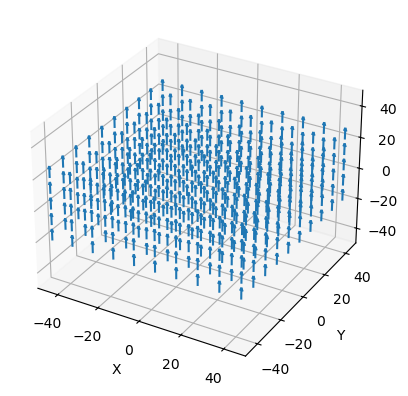

In [241]:
ax = plt.figure().add_subplot(projection='3d')
x, y, z = np.meshgrid(np.arange(-x_sample_size/nm/2+x_discretization_size/nm/2, x_sample_size/nm/2, x_discretization_size/nm),
                      np.arange(-y_sample_size/nm/2+y_discretization_size/nm/2, y_sample_size/nm/2, y_discretization_size/nm),
                      np.arange(-z_sample_size/nm/2+z_discretization_size/nm/2, z_sample_size/nm/2, z_discretization_size/nm))

u = M_array_cartesian[:,:,:,0]
v = M_array_cartesian[:,:,:,1]
w = M_array_cartesian[:,:,:,2]

ax.quiver(x, y, z, u, v, w, length=0.75*z_discretization_size/nm, normalize=False)
ax.set_xlim(-x_sample_size/nm/2, x_sample_size/nm/2)
ax.set_ylim(-y_sample_size/nm/2, y_sample_size/nm/2)
ax.set_zlim(-50, 50)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

## Calculate magnetic field from sample at an arbitract point in space

In [260]:
def B_at_coord(coord_calc: Tuple[float, float, float], 
               M_array: np.ndarray, 
               sample_dims: Tuple[float, float, float], 
               sample_disc: Tuple[float, float, float], 
               sample_grid: Tuple[int, int, int]
              ) -> Tuple[float, float, float]:
    
    B_vec = np.zeros(3)

    for ix in range(sample_grid[0]):
        for iy in range(sample_grid[1]):
            for iz in range(sample_grid[2]):
                center_coord = (-sample_dims[0]/2+sample_disc[0]/2 + ix*sample_disc[0], 
                                -sample_dims[1]/2+sample_disc[1]/2 + iy*sample_disc[1], 
                                -sample_dims[2]/2+sample_disc[2]/2 + iz*sample_disc[2])
                m_i = M_array[ix, iy, iz, 0]
                theta_i = M_array[ix, iy, iz, 1]
                phi_i = M_array[ix, iy, iz, 2]

                B_components = B_i(m_i, coord_calc, center_coord, theta_i, phi_i)
                B_vec[0] += B_components[0]
                B_vec[1] += B_components[1]
                B_vec[2] += B_components[2]
    return B_vec

### Sanity checks

In [271]:
coord_calc = (0, 0, dist_to_sample)
print("Field components at (0,0,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc = (dist_to_sample, dist_to_sample, dist_to_sample)
print("Field components at (d,d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc = (-dist_to_sample, -dist_to_sample, dist_to_sample)
print("Field components at (-d,-d,d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc = (dist_to_sample, 0, 0)
print("Field components at (d,0,0)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

coord_calc = (0, 0, 10*dist_to_sample)
print("Field components at (0,0,10d)", B_at_coord(coord_calc, M_array, sample_dimensions, sample_discretization_size, sample_grid))

Field components at (0,0,d) [4.62500000e+00 2.68750000e+00 5.25033204e+16]
Field components at (d,d,d) [2.31880074e+15 2.31880074e+15 5.56787992e+14]
Field components at (-d,-d,d) [-2.31880074e+15 -2.31880074e+15  5.56787992e+14]
Field components at (d,0,0) [-2.07031250e-01 -1.95312500e-03 -1.25953663e+16]
Field components at (0,0,10d) [4.01735306e-05 2.58684158e-05 1.41576663e+13]


## Define probe and fluctuations

In [283]:
probe_side = 50*nm
dist_to_sample = 200*nm

probe_area = probe_side**2

delta_a = 1*nm
del_x = 1*nm
del_y = 1*nm

## Calculating magnetic flux through SQUID loop at distance d above sample center

In [313]:
meshing_probe = (100, 100) # nx, ny
da_probe = (probe_side/meshing_probe[0])**2
coord_calc = (0, 0, 500*nm)

flux_arr = np.zeros(meshing_probe)

for ix in range(meshing_probe[0]):
    for iy in range(meshing_probe[1]):
        print(ix, iy)
        coord_calc_ix_iy = (coord_calc[0]-probe_side/2 + delta_a*(ix + 0.5), coord_calc[1]-probe_side/2 + delta_a*(iy + 0.5), coord_calc[2])
        B_probe_segment = B_at_coord(coord_calc_ix_iy, M_array, sample_dimensions, sample_discretization_size, sample_grid)
        flux_arr[ix, iy] = B_probe_segment[2]*(da_probe**2)
        
        

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
1 84
1 85
1 86
1 87
1 88
1 89
1 90
1 91
1 92
1 93
1 94
1 95
1 96
1 97
1 98
1 99
2 0
2 1
2 2
2 3
2 4


In [336]:
flux = np.sum(flux_arr)
print(flux/(nm**2))

0.8104359783862362


### Plotting magnetic flux per unit cell of probe meshing

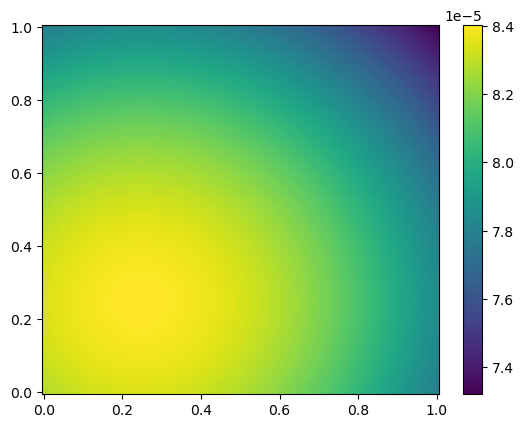

In [333]:
fig, ax = plt.subplots()
im = plt.pcolormesh(np.linspace(0,1,100), np.linspace(0,1,100), flux_arr/(nm**2))
fig.colorbar(im, ax=ax)

In [327]:
np.min(flux_arr)/(nm**2)

7.321439609331946e-05